## Deep Researcher
### Using Orchestrator And Synthesizer
- given a topic creates a plan
  - i.e. sections
- for every section tools are available
  - search arxiv
  - search internet (tavilysearch)
- summarizes information
- checks if revision is required or more searches are required
- creates final summary

In [1]:
import os
import re
from dotenv import load_dotenv
import operator

from pydantic import BaseModel, Field
from typing import List, Optional, Dict
from typing_extensions import Annotated, Literal, TypedDict

from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI

from langgraph.constants import Send
from langgraph.types import interrupt, Command
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, SystemMessage

# tools
from langchain_community.retrievers import WikipediaRetriever
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_google_community import GoogleSearchAPIWrapper
from langchain_community.retrievers import ArxivRetriever



from langgraph.checkpoint.memory import MemorySaver

from IPython.display import display, Markdown, Image

/run/media/kuldeepsingh/Work/venv_environments/ai_agents_experiments/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
openai_llm = ChatOpenAI(
    temperature=0,
    model="gpt-4o-mini",
    max_tokens=500,
    openai_api_key=os.environ["OPENAI_API_KEY"],
)

# deepseek_llm = ChatGroq(
#     temperature=0,
#     model="deepseek-r1-distill-qwen-32b",
#     max_tokens=2048,
#     groq_api_key=os.enviResearchWorkerStateron["GROQ_API_KEY"],
#     max_retries=3,
# )


# google_llm = ChatGoogleGenerativeAI(
#     temperature=0,
#     model="gemini-1.5-flash",
#     max_output_tokens=1024,
#     google_api_key=os.environ["GOOGLE_API_KEY"],
# )


class TopicList(BaseModel):
    topics: List[str] = Field(
        description="List of topics which will be helpful in understanding. Must not be more than three topics.",
    )

topic_identifying_llm = ChatGoogleGenerativeAI(
    temperature=0,
    model="gemini-1.5-flash",
    max_output_tokens=1024,
    google_api_key=os.environ["GOOGLE_API_KEY"],
).with_structured_output(TopicList)


class Section(BaseModel):
    title: str = Field(
        description="Title of the section",
    )
    content: str = Field(
        description="Content of the section",
    )
    sources: List[str] = Field(
        description="List of sources for the section like urls links.",
    )

section_writer_llm = openai_llm.with_structured_output(Section)

In [3]:
topic = "Singh"

# use wikipedia retriever
wikipedia_retriever = WikipediaRetriever(
    top_k_results=3
)

# wiki_results = wikipedia_retriever.invoke(f"{topic}")

In [6]:
topic = "Large Language Models"

# use tavily search
search_tavily = TavilySearchResults(
    api_key=os.environ["TAVILY_API_KEY"],
    max_results=2
)
# tavily_search_results = search_tavily.invoke(f"{topic}")
# len(tavily_search_results)
# tavily_search_results

In [7]:
# using arxiv retriever
arxiv_retriever = ArxivRetriever(
    load_max_docs=2
)

# arxiv_results = arxiv_retriever.invoke(f"{topic}")
# len(arxiv_results)

In [8]:
def preprocess_long_text(text):
    """Preprocess long text by removing newlines and tabs."""
    # Remove newlines and tabs
    text = re.sub(r'[\n\t]+', ' ', text)
    
    # Truncate to 1000 characters
    if len(text) > 1000:
        text = text[:1000]
    
    return text

In [37]:
class SearchGraphState(TypedDict):
    """State for the Research Worker agent."""
    topic: str
    of_section: str
    search_query: str
    current_section: str
    search_results: Annotated[list, operator.add]

In [39]:
def create_search_query(state: SearchGraphState):
    """Create a search query for the topic."""
    print(state)
    return {
        "search_query": f"{state['topic']} in {state['of_section']}"
    }

def tavily_search(state:SearchGraphState):
    """Search Tavily for the topic."""
    search_results = search_tavily.invoke(state["search_query"])
    formatted_results = []
    for result in search_results:
        formatted_results.append(
            {   "search_query": state["search_query"],
                "title": "",
                "source": result["url"],
                "content": preprocess_long_text(result["content"])
            }
        )
    return {
        "search_results": formatted_results
    }

def arxiv_search(state:SearchGraphState):
    """Search Arxiv for the topic."""
    search_results = arxiv_retriever.invoke(state["search_query"])
    
    formatted_results = []
    for result in search_results:
        formatted_results.append(
            {   "search_query": state["search_query"],
                "title": result.metadata["Title"],
                "source": result.metadata["Entry ID"],
                "content": preprocess_long_text(result.page_content)
            }
        )
    return {
        "search_results": formatted_results
    }
    
def wikipedia_search(state:SearchGraphState):
    """Search Wikipedia for the topic."""
    search_results = wikipedia_retriever.invoke(state["search_query"])
    
    formatted_results = []
    for result in search_results:
        formatted_results.append(
            {   "search_query": state["search_query"],
                "title": result.metadata["title"],
                "source": result.metadata["source"],
                "content": preprocess_long_text(result.metadata["summary"])
            }
        )
        
    return {
        "search_results": formatted_results
    }

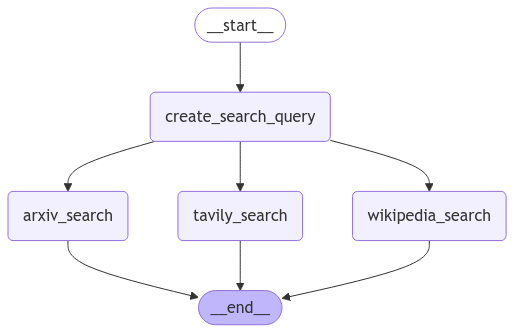

In [40]:
search_graph_builder = StateGraph(SearchGraphState)
search_graph_builder.add_node("create_search_query", create_search_query)
search_graph_builder.add_node("tavily_search", tavily_search)
search_graph_builder.add_node("arxiv_search", arxiv_search)
search_graph_builder.add_node("wikipedia_search", wikipedia_search)

search_graph_builder.add_edge(
    START, "create_search_query"
)

search_graph_builder.add_edge(
    "create_search_query", "tavily_search"
)
search_graph_builder.add_edge(
    "create_search_query", "arxiv_search"
)
search_graph_builder.add_edge(
    "create_search_query", "wikipedia_search"
)
search_graph_builder.add_edge(
    ["tavily_search", "arxiv_search", "wikipedia_search"], END
)
search_graph = search_graph_builder.compile()
display(Image(search_graph.get_graph().draw_mermaid_png()))

In [44]:
# input_search_state = {
#     "topic": 'Model Architectures',
#     "of_section": "Introduction to Large Language Models"
# }
# out = search_graph.invoke(input_search_state)

In [45]:
# out

In [ ]:
class ResearcherState(TypedDict):
    """State for the Researcher agent."""
    section: str
    section_overview: str
    topics_of_section: list
    compiled_section: Section
    search_results: Annotated[list, operator.add]


In [58]:
def get_important_topics(state: ResearcherState):
    """Get important topics from the research worker."""
    out = topic_identifying_llm.invoke(
        [
            SystemMessage(content="Given a section title and overview. Identify the topics which will be helpful in understanding the section. The topics must be less than 3 and must be relevant to the section."),
            HumanMessage(content=f"Section: {state['section']}\nSection Overview: {state['section_overview']}"),
        ]
    )
    print(out.topics)
    return {
        "topics_of_section": out.topics
    }



def assign_search_workers(state: ResearcherState):
    """Assign search workers to the topics."""
    return [
        Send("execute_search_graph", {"topic": topic, "of_section": state["section"]}) for topic in state["topics_of_section"]
    ]


def section_writer(state: ResearcherState):
    """Synthesize the section."""
    out = section_writer_llm.invoke(
        [
            SystemMessage(content="You are a research assistant. You will be given a section title and overview. You will be given search results, filter them and select the useful ones to write the content of the section."),
            HumanMessage(content=f"Section: {state['section']}\nSection Overview: {state['section_overview']}\n  Search Results: {state['search_results']}"),
        ]
    )
    return {
        "compiled_section": out
    }

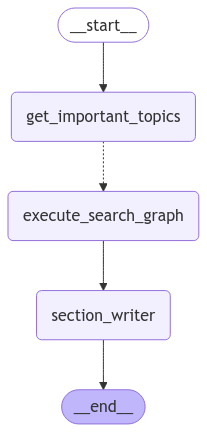

In [59]:
graph_builder = StateGraph(ResearcherState)

graph_builder.add_node("get_important_topics", get_important_topics)
graph_builder.add_node("execute_search_graph", search_graph_builder.compile())
graph_builder.add_node("section_writer", section_writer)

graph_builder.add_edge(START, "get_important_topics")
graph_builder.add_conditional_edges(
    "get_important_topics", assign_search_workers, ["execute_search_graph"]
)
graph_builder.add_edge("execute_search_graph", "section_writer")
graph_builder.add_edge("section_writer", END)

# memory = MemorySaver()

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [60]:
config = {"configurable": {"thread_id": "1"}}

input_researcher_state = {
    "section": "Introduction to Large Language Models",
    "section_overview": "This section will cover the basics of large language models, their architecture, and their applications.",
}

out = graph.invoke(input_researcher_state, config=config)

['Model Architectures', 'Applications of LLMs', 'Basic Concepts of LLMs']
{'topic': 'Model Architectures', 'of_section': 'Introduction to Large Language Models', 'search_results': []}
{'topic': 'Applications of LLMs', 'of_section': 'Introduction to Large Language Models', 'search_results': []}
{'topic': 'Basic Concepts of LLMs', 'of_section': 'Introduction to Large Language Models', 'search_results': []}


In [61]:
print(out["compiled_section"].title)
print(out["compiled_section"].content)

Introduction to Large Language Models
Large Language Models (LLMs) are a transformative class of artificial intelligence designed to understand and generate human-like text. They are built on advanced architectures, primarily the Transformer model, which utilizes attention mechanisms to process and generate language efficiently. LLMs are characterized by their vast number of parameters and extensive training on diverse datasets, enabling them to perform a wide range of language-based tasks, including text generation, summarization, translation, and question answering.

The architecture of LLMs can be categorized into several types: encoder-only models (like BERT), decoder-only models (like GPT), and encoder-decoder models (like T5). Each architecture serves different purposes, with encoder-only models focusing on understanding and contextualizing input text, while decoder-only models are adept at generating coherent and contextually relevant text outputs.

LLMs are trained using self-s

In [62]:
out["compiled_section"].sources

['https://whylabs.ai/learning-center/introduction-to-llms/understanding-large-language-model-architectures',
 'https://developers.google.com/machine-learning/resources/intro-llms',
 'https://en.wikipedia.org/wiki/Large_language_model']